This is Will's edit of a notebook originally written by Javier.

# Correlations between H II region parameters

We look at correlations between 6 principal measurements that fall into two groups: 

* Basic parameters: 
    * Size: $L$
    * Ionizing luminosity: $Q(\mathrm{H})$
    * Distance: $D$
* Velocity structure function parameters:
    * Velocity dispersion on plane of sky: $\sigma$
    * Velocity autocorrelation length scale: $\ell_0$
    * Structure function slope in inertial range: $m$

Colab's markdown renderer seems to have a bug that requires some math outside of a list in order to trigger latex parsing: $\alpha$. 

## Original table from Javier

In [1]:
import time
start_time=time.time()
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import lmfit
import statsmodels.api as sm
import linmix
from scipy.stats import pearsonr
import pickle

In [2]:
Region =["NGC 604","NGC 595","Hubble X","Hubble V","30Dor" ,"Carina","NGC 346","M8"   ,"OrionL","OrionS"]
LHa    =[4.46e39  ,2.29e39  ,3.98e38   ,7.41e38   ,5.74e39 ,3.98e39 ,4.67e38  ,2.95e37,1e37    ,1e37    ]
SFR    =[5.3e-3   ,2.6e-3   ,3.1e-4    ,1.5e-4    ,1.3e-2  ,1.0e-2  ,0.0021   ,1.0e-4 ,5.3e-5  ,5.3e-5  ]
n      =[3        ,4        ,5         ,8         ,250     ,500     ,100      ,60     ,150     ,4000    ] 
Diam   =[400      ,400      ,160       ,130       ,98.9    ,5       ,64       , 25    ,5       ,0.6     ]
R      =[200      ,200      ,80        ,65        ,49.4    ,7.5     ,32       ,12.5   ,2.5     ,0.3     ]
Dist   =[840      ,840      ,500       ,500       ,50      ,2.35    ,61.7     ,1.25   ,0.4     ,0.4     ]
siglos =[16.21    ,18.33    ,12.3      ,13.4      ,31.7    ,22.46   ,10.2     ,13.6   ,6       ,6       ]
sigW   =[23.1     ,27.1     ,13.4      ,14.7      ,31.7    ,22.46   ,10.2     ,13.6   ,6       ,6       ]

In [3]:
samples=pd.read_csv('CIresults//list2.csv',header=None)
samples

,0
0,N604H
1,N595
2,HX
3,HV
4,Dor
5,CarC
6,N346
7,M8
8,OrionLH
9,OrionS


In [4]:
CI = {}

for i in range(len(samples)):
    pickle_in = open('Results//CI' + samples[0][i] + '.pkl',"rb")
    df = pickle.load(pickle_in)
    CI[samples[0][i]] = df

SF = {}

for i in range(len(samples)):
    pickle_in = open('Results//SF' + samples[0][i] + '.pkl',"rb")
    df = pickle.load(pickle_in)
    SF[samples[0][i]] = df

Reults

In [5]:
sig = [[0]*(1) for i in range(len(samples))]
siger = [[0]*(1) for i in range(len(samples))]
sig2 = [[0]*(1) for i in range(len(samples))]
sig2er = [[0]*(1) for i in range(len(samples))]
r0 = [[0]*(1) for i in range(len(samples))]
r0er = [[0]*(1) for i in range(len(samples))]
m = [[0]*(1) for i in range(len(samples))]
mer = [[0]*(1) for i in range(len(samples))]

for i in range(len(samples)):
    sig[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].value,4)**0.5
    siger[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].stderr,4)**0.5
    sig2[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].value,4)
    r0[i] = np.round(CI[samples[0][i]]['result'].params['r0'].value,4)
    m[i] = np.round(CI[samples[0][i]]['result'].params['m'].value,4)
    sig2er[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].stderr,4)
    r0er[i] = np.round(CI[samples[0][i]]['result'].params['r0'].stderr,4)
    mer[i] = np.round(CI[samples[0][i]]['result'].params['m'].stderr,4)
  

In [6]:
data = pd.DataFrame(
    {
       "Region": Region,
       "LHa": LHa,
       "SFR": SFR,
       "n": n,
       "L [pc]": Diam,
       "R [pc]": R,
       "Dist [kpc]": Dist,
       "sig2 [km/s]": sig2,
       "sig2er": sig2er,
       "sig [km/s]": sig,
       "siger": siger,
       "m": m,
       "mer": mer,
       "r0 [pc]": r0,
       "r0er": r0er,
       "siglos [km/s]": siglos,
      
    },
)

Checar que los tipos de las columnas sean adecuadas:

In [7]:
data.dtypes

Region            object
LHa              float64
SFR              float64
n                  int64
L [pc]           float64
R [pc]           float64
Dist [kpc]       float64
sig2 [km/s]      float64
sig2er           float64
sig [km/s]       float64
siger            float64
m                float64
mer              float64
r0 [pc]          float64
r0er             float64
siglos [km/s]    float64
dtype: object

In [8]:
data

,Region,LHa,SFR,n,L [pc],R [pc],Dist [kpc],sig2 [km/s],sig2er,sig [km/s],siger,m,mer,r0 [pc],r0er,siglos [km/s]
0,NGC 604,4.460000e+39,0.005300,3,400.0,200.0,840.00,78.4869,15.8821,8.859283,3.985235,0.8820,0.2890,11.2830,2.8844,16.21
1,NGC 595,2.290000e+39,0.002600,4,400.0,200.0,840.00,54.4052,5.2051,7.375988,2.281469,1.3867,0.1141,11.6964,0.5616,18.33
2,Hubble X,3.980000e+38,0.000310,5,160.0,80.0,500.00,15.5778,1.7187,3.946872,1.310992,0.9674,0.1344,3.7527,0.4395,12.30
3,Hubble V,7.410000e+38,0.000150,8,130.0,65.0,500.00,11.5293,1.7946,3.395482,1.339627,0.6641,0.1732,4.4671,0.6989,13.40
4,30Dor,5.740000e+39,0.013000,250,98.9,49.4,50.00,345.1889,28.4832,18.579260,5.336965,0.8520,0.0537,4.5020,0.5719,31.70
5,Carina,3.980000e+39,0.010000,500,5.0,7.5,2.35,18.1961,24.5619,4.265689,4.955996,1.1583,1.1522,0.5870,0.4390,22.46
6,NGC 346,4.670000e+38,0.002100,100,64.0,32.0,61.70,37.6048,1.3358,6.132275,1.155768,0.7981,0.0325,1.8765,0.1159,10.20
7,M8,2.950000e+37,0.000100,60,25.0,12.5,1.25,16.5567,111.7329,4.068993,10.570378,0.9581,4.5406,2.7226,15.9247,13.60
8,OrionL,1.000000e+37,0.000053,150,5.0,2.5,0.40,6.2015,2.0147,2.490281,1.419401,1.8480,0.1782,0.5554,0.2465,6.00
9,OrionS,1.000000e+37,0.000053,4000,0.6,0.3,0.40,16.6820,0.8609,4.084360,0.927847,1.0734,0.0167,0.0903,0.0058,6.00


## Change to log scale for most parameters

El analisis de la mayoría de las columnas sería mejor en escala logarítmica porque varían por varios ordenes de magnitud.  Entonces, hacemos una nueva versión de la tabla así. Dejamos la $m$ en escala lineal porque no varía mucho.

In [9]:
cols = data.columns
logdata = data.copy()
for col in cols:
    if col not in ["Region", "m", "mer", "r0er", "siger",  "sig2er",]:
        logdata[col] = np.round(np.log10(logdata[col]), 2)
        logdata.rename(columns={col: f"log {col}"}, inplace=True)
# Some minor changes to column names
logdata.rename(
    columns={
        "log LHa": "log L(H) [erg s^-1]",
        }, 
    inplace=True)
logdata

,Region,log L(H) [erg s^-1],log SFR,log n,log L [pc],log R [pc],log Dist [kpc],log sig2 [km/s],sig2er,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log siglos [km/s]
0,NGC 604,39.65,-2.28,0.48,2.60,2.30,2.92,1.89,15.8821,0.95,3.985235,0.8820,0.2890,1.05,2.8844,1.21
1,NGC 595,39.36,-2.59,0.60,2.60,2.30,2.92,1.74,5.2051,0.87,2.281469,1.3867,0.1141,1.07,0.5616,1.26
2,Hubble X,38.60,-3.51,0.70,2.20,1.90,2.70,1.19,1.7187,0.60,1.310992,0.9674,0.1344,0.57,0.4395,1.09
3,Hubble V,38.87,-3.82,0.90,2.11,1.81,2.70,1.06,1.7946,0.53,1.339627,0.6641,0.1732,0.65,0.6989,1.13
4,30Dor,39.76,-1.89,2.40,2.00,1.69,1.70,2.54,28.4832,1.27,5.336965,0.8520,0.0537,0.65,0.5719,1.50
5,Carina,39.60,-2.00,2.70,0.70,0.88,0.37,1.26,24.5619,0.63,4.955996,1.1583,1.1522,-0.23,0.4390,1.35
6,NGC 346,38.67,-2.68,2.00,1.81,1.51,1.79,1.58,1.3358,0.79,1.155768,0.7981,0.0325,0.27,0.1159,1.01
7,M8,37.47,-4.00,1.78,1.40,1.10,0.10,1.22,111.7329,0.61,10.570378,0.9581,4.5406,0.43,15.9247,1.13
8,OrionL,37.00,-4.28,2.18,0.70,0.40,-0.40,0.79,2.0147,0.40,1.419401,1.8480,0.1782,-0.26,0.2465,0.78
9,OrionS,37.00,-4.28,3.60,-0.22,-0.52,-0.40,1.22,0.8609,0.61,0.927847,1.0734,0.0167,-1.04,0.0058,0.78


Uncertainties Log Space

In [10]:
logdata['mer']=(data['mer']/data['m'])*0.434

In [11]:
logdata['r0er']=(data['r0er']/data['r0 [pc]'])*0.434

In [12]:
logdata['siger']=(data['siger']/data['sig [km/s]'])*0.434

In [13]:
logdata['sig2er']=(data['sig2er']/data['sig2 [km/s]'])*0.434

Make the label text bigger on the figures

In [14]:
sns.set_context("talk")

Repeat the pair plot of correlations between columns with the log-scale quantities. Use color to indicate the distance to the regions.

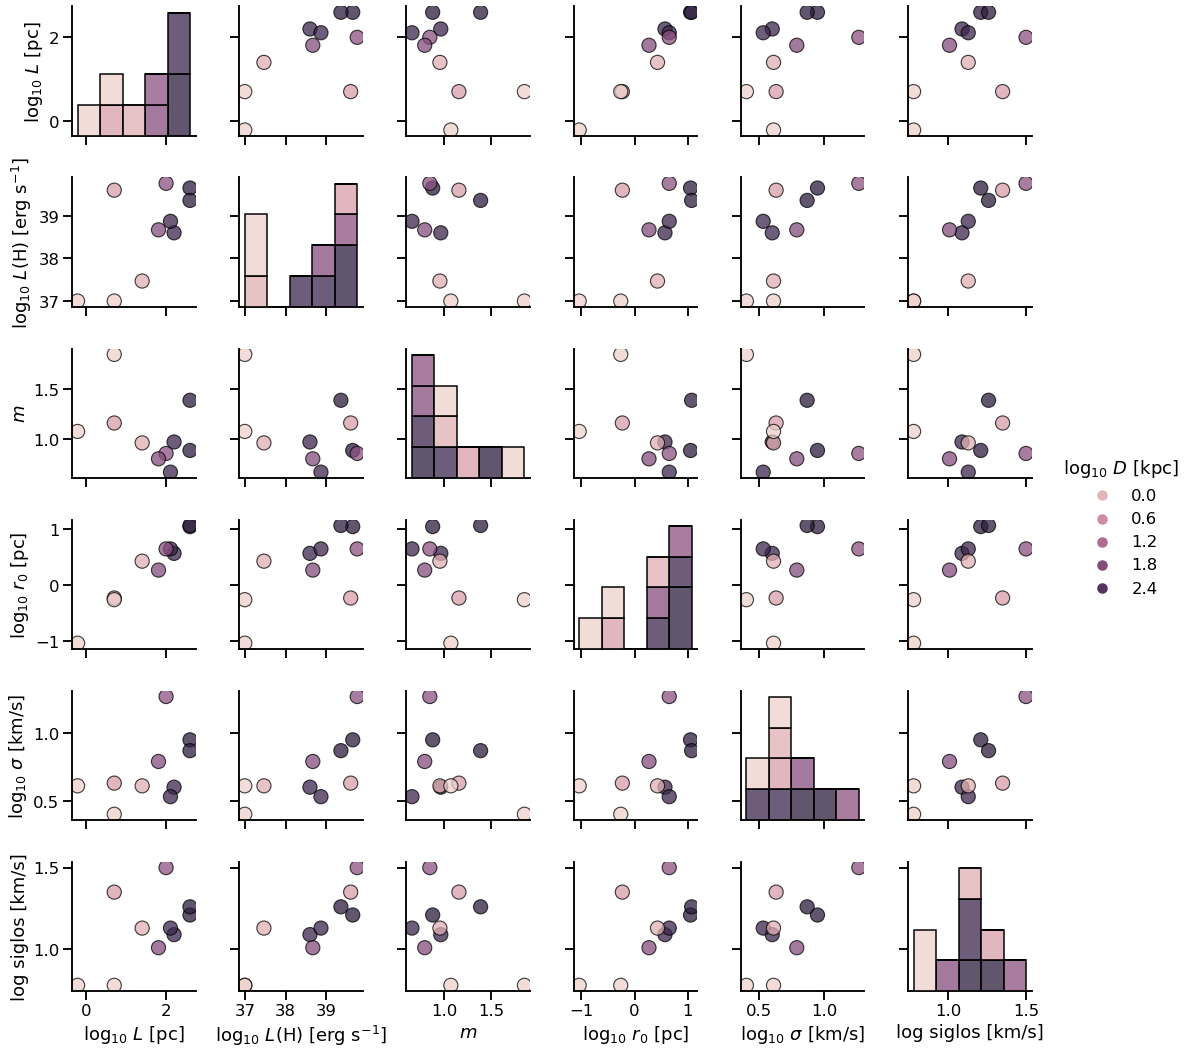

In [15]:
selected_vars = [ "log L [pc]","log L(H) [erg s^-1]", "log Dist [kpc]", "m", "log r0 [pc]", "log sig [km/s]", "log siglos [km/s]"]
plotdata = logdata[selected_vars].rename(
    columns={
        # Switch column names to use latex formatting to improve axis labels
        "log L [pc]": r"$\log_{10}\ L$ [pc]", 
        "log L(H) [erg s^-1]": r"$\log_{10}\ L(\mathrm{H})$ [erg s$^{-1}$]", 
        "m": "$m$", 
        "log r0 [pc]": r"$\log_{10}\ r_0$ [pc]", 
        "log sig [km/s]": r"$\log_{10}\ \sigma$ [km/s]", 
        "log Dist [kpc]": r"$\log_{10}\ D$ [kpc]",
    },
)

sns.pairplot(plotdata, 
             hue=r"$\log_{10}\ D$ [kpc]",
             plot_kws=dict(alpha=0.75, s=200, edgecolor="k"), 
             diag_kind='hist',
             diag_kws= dict(multiple='stack'),
             );

figname = "strucfunc-correlations"
# Save PDF and JPG versions of the figure
#plt.gcf().savefig(f"{figname}.pdf")
#plt.gcf().savefig(f"{figname}.jpg")

## Correlation coefficients

Calculate [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), $r$, between each pair of variables:

In [16]:
logdata[selected_vars].corr()

,log L [pc],log L(H) [erg s^-1],log Dist [kpc],m,log r0 [pc],log sig [km/s],log siglos [km/s]
log L [pc],1.000000,0.674686,0.923364,-0.365401,0.980149,0.493252,0.555372
log L(H) [erg s^-1],0.674686,1.000000,0.714755,-0.412457,0.663533,0.683838,0.875549
log Dist [kpc],0.923364,0.714755,1.000000,-0.462007,0.850699,0.436535,0.477683
m,-0.365401,-0.412457,-0.462007,1.000000,-0.313576,-0.373836,-0.387023
log r0 [pc],0.980149,0.663533,0.850699,-0.313576,1.000000,0.497735,0.616539
log sig [km/s],0.493252,0.683838,0.436535,-0.373836,0.497735,1.000000,0.714706
log siglos [km/s],0.555372,0.875549,0.477683,-0.387023,0.616539,0.714706,1.000000


So the results for correlations between the basic parameters are what we would expect:

- Size is moderately correlated with luminosity ($r = 0.67$).  The correlation is only weak because size will also depend on ambient density and the age of the region. 
- Size is highly correlated with distance ($r = 0.92$).  This is just a selection effect due to the fact that we tend to choose regions that have an angular size that matches our instruments. 
- Luminosity–distance correlation is the weakest ($r = 0.71$), and can be explained as being due to the previous two.



The correlations of the structure function parameters with the basic parameters are very interesting:
- Autocorrelation length scale, $r_0$, is *highly* correlated ($r = 0.96$) with region size, $L$.  Looking at the graph, the relation seems to be approximately linear with $\ell_0 \approx 0.1 L$.  How much of this correlation is real and how much is down to selection effects is something we need to consider carefully.
- Velocity dispersion, $\sigma$, is well correlated ($r = 0.71$) with luminosity, $L(\mathrm{Ha})$.  
- The structure function slope $m$ is well correlated ($r = 0.73$) with distance.  This is mainly because $m \approx 1.6$ for all the distant regions observed with TAURUS and ISIS, but is around $m = 1$ for all the nearby regions.  I suspect that this is mainly a data quality issue: we observe very little of the inertial range in the distant regions, so the determination of $m$ is probably not so reliable.  But I am not sure why this would tend to bias $m$ towards high values.  

## Significance tests

We can calculate the statistical significance of the correlations by using the Student t-statistic.  We test the null hypothesis that a given pair of variables is truly uncorrelated ($r = 0$) for the underlying population and that the observed $r$ for our sample of $N = 9$ sources arises solely by chance.  We want to calculate the $p$-value, which is the probability of obtaining $r$ greater than or equal to the observed value, given that there is no true correlation.  A small value of $p$ means that the null hypothesis can be rejected at a certain confidence level.  

First we calculate the t-statistic from the Pearson correlation coefficient:
$$
t = r \, \left(\frac{N - 2}{1 - r^2}\right)^{1/2}
$$
Then, we use the cumulative distribution function (CDF) of the t-distribution with $N - 1$ degrees of freedom to find the p-value. 

In [17]:
def tstatistic(r, n):
    """Compute Student t statistic for null hypothesis of no correlation
    for an observed Pearson correlation of `r` from `n` samples
    """
    return r*np.sqrt((n - 2) / (1 - r**2))

In [18]:
import scipy.stats

In [19]:
def p_from_t(t, n):
    """Compute 1-sided p-value from Student statistic `t` with `n` observations"""
    # sf is survival function: 1 - CDF
    return scipy.stats.t.sf(t, n-1)
    

In [20]:
N = 9
rvals = np.array([0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.779, 0.8, 0.9, 0.908, 0.95, 0.981])
tvals = tstatistic(rvals, N)
pvals = p_from_t(tvals, N)
pd.DataFrame(
    {"r": rvals, "t": tvals, "p": pvals}
)

,r,t,p
0,0.000,0.000000,5.000000e-01
1,0.200,0.540062,3.019294e-01
2,0.400,1.154701,1.407685e-01
3,0.500,1.527525,8.257494e-02
4,0.600,1.984313,4.124805e-02
5,0.700,2.593355,1.597303e-02
6,0.779,3.287020,5.535582e-03
7,0.800,3.527668,3.879201e-03
8,0.900,5.462793,2.997718e-04
9,0.908,5.733922,2.184923e-04


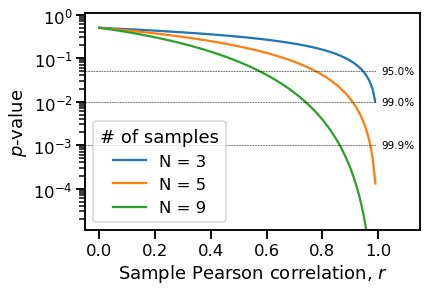

In [21]:
fig, ax = plt.subplots()
for N in 3, 5, 9:
    rvals = np.linspace(0.0, 1.0, 100, endpoint=False)
    tvals = tstatistic(rvals, N)
    pvals = p_from_t(tvals, N)
    ax.plot(rvals, pvals, label=f"N = {N}")
for p0 in 0.05, 0.01, 0.001:
    ax.axhline(p0, color="k", ls="--", lw=0.5)
    ax.text(1.07, p0, f"{100*(1-p0):.1f}%", 
            va="center", ha="center", fontsize="xx-small", 
            bbox={"color": "w"})
ax.legend(title="# of samples")
ax.set(
    xlabel="Sample Pearson correlation, $r$",
    ylabel="$p$-value",
    yscale="log",
    xlim=[-0.05, 1.15],
    ylim=[1.1e-5, 1.1],
);

I have marked confidence levels for nominal $p$-values of 0.05, 0.01, and 0.001, which are often used to judge significance.   This implies that all the correlations that we listed above are highly significant.  For instance, the correlation of $\sigma$ with luminosity, with $r=0.77$, has $p = 0.011$, so close to the 99% confidence level. 

Despite the good correlation, there is a factor of 4 difference in $\sigma$ between Carina and 30~Dor, despite similar luminosities.  **Need to check these luminostiy values**. 

In [22]:
logdata

,Region,log L(H) [erg s^-1],log SFR,log n,log L [pc],log R [pc],log Dist [kpc],log sig2 [km/s],sig2er,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log siglos [km/s]
0,NGC 604,39.65,-2.28,0.48,2.60,2.30,2.92,1.89,0.087821,0.95,0.195229,0.8820,0.142206,1.05,0.110948,1.21
1,NGC 595,39.36,-2.59,0.60,2.60,2.30,2.92,1.74,0.041522,0.87,0.134241,1.3867,0.035710,1.07,0.020838,1.26
2,Hubble X,38.60,-3.51,0.70,2.20,1.90,2.70,1.19,0.047883,0.60,0.144157,0.9674,0.060295,0.57,0.050828,1.09
3,Hubble V,38.87,-3.82,0.90,2.11,1.81,2.70,1.06,0.067555,0.53,0.171227,0.6641,0.113189,0.65,0.067901,1.13
4,30Dor,39.76,-1.89,2.40,2.00,1.69,1.70,2.54,0.035811,1.27,0.124668,0.8520,0.027354,0.65,0.055132,1.50
5,Carina,39.60,-2.00,2.70,0.70,0.88,0.37,1.26,0.585832,0.63,0.504233,1.1583,0.431714,-0.23,0.324576,1.35
6,NGC 346,38.67,-2.68,2.00,1.81,1.51,1.79,1.58,0.015417,0.79,0.081797,0.7981,0.017673,0.27,0.026806,1.01
7,M8,37.47,-4.00,1.78,1.40,1.10,0.10,1.22,2.928849,0.61,1.127440,0.9581,2.056800,0.43,2.538500,1.13
8,OrionL,37.00,-4.28,2.18,0.70,0.40,-0.40,0.79,0.140995,0.40,0.247370,1.8480,0.041850,-0.26,0.192620,0.78
9,OrionS,37.00,-4.28,3.60,-0.22,-0.52,-0.40,1.22,0.022397,0.61,0.098592,1.0734,0.006752,-1.04,0.027876,0.78


In [23]:
#logdata=logdata.drop(9, axis=0)
#logdata

r0 vs m

In [24]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','m', 'mer']]

In [25]:
Y=np.log10(Y)

[Text(0, 0.5, 'log$ m$'), Text(0.5, 0, 'log$ r_{0}$ [pc]')]

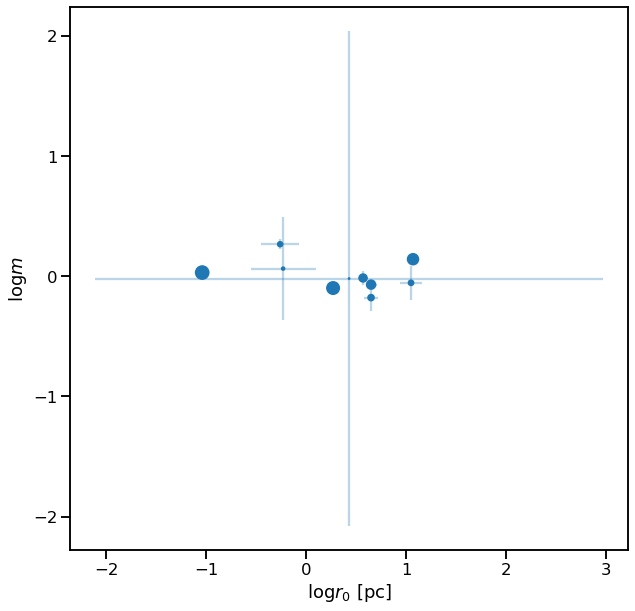

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log$ r_{0}$ [pc]", ylabel=r"log$ m$",
)
#ax.set_aspect("equal")
#sns.despine()

In [27]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [28]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99894585 0.9968416  1.03553963 1.04101673 0.99998827 0.99416308]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99674788 1.00151818 0.99614013 0.99789871 1.00124834 1.00715474]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99937797 1.00055767 1.00248495 1.00796236 1.00077082 1.00522245]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99891262 1.00178462 1.00030921 1.00804816 1.00041411 1.0043626 ]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99892396 1.0019092  0.9991969  1.00644302 1.00036604 1.00332078]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99917588 0.9993077  1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99981693 0.99983523 1.00031378 1.00035482 1.00001747 1.00004068]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99984472 0.99984524 1.00029117 1.00036914 1.00001671 1.00003125]


In [29]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,0.064353,-0.068489,0.019526,"[0.26462300123359833, 0.7353769987664017]","[-0.5442078803845228, 0.12440275264233781]","[4.350064611707959, 0.38517337199284213]",0.236881,0.361749,0.778772,-0.052527,1.233437,-0.517357
1,0.164167,-0.170643,0.067027,"[0.07436394013478448, 0.9256360598652155]","[-0.11493087936698476, 0.2397000535984746]","[1.9701504346575847, 0.174938813605889]",-0.114430,0.283573,0.763334,0.213328,0.563112,-0.347964
2,-0.009257,0.107970,0.029101,"[0.06446675635718957, 0.9355332436428104]","[-0.051125833113397454, 0.6757019460482945]","[0.31403529809446373, 0.5107718826200359]",0.655701,0.290891,0.666698,0.628846,0.727977,0.418469
3,-0.037254,-0.038409,0.039194,"[0.0635093321831824, 0.9364906678168176]","[0.11638757998678839, 0.20854786169873502]","[5.387546674235761, 0.6719568813234089]",0.458158,0.183079,0.373710,0.202695,0.985873,-0.187862
4,-0.052817,-0.076850,0.018248,"[0.01771344387363856, 0.9822865561263615]","[0.7109312718567904, 0.5133361688801118]","[123.3804178361905, 0.8471255578677461]",0.919492,0.220534,0.697905,0.516836,1.737323,-0.702959
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.060008,0.039643,0.348296,"[0.6495823156319207, 0.3504176843680792]","[0.6931908403686433, 0.08435639808681179]","[0.5930237156705503, 0.7695708757043423]",0.018040,0.432626,0.660031,0.479844,0.859805,0.057660
9996,-0.117205,0.045946,0.029309,"[0.70021377960963, 0.29978622039036995]","[0.7669888922472516, -0.234264280673224]","[0.23714783789490804, 1.4211599103297263]",0.359057,0.575925,1.197145,0.466827,0.895846,0.233766
9997,-0.038717,-0.076444,0.026626,"[0.6888274231937033, 0.3111725768062966]","[0.8279310470795261, -0.1566944661536745]","[0.36282185154405594, 0.2699481858079233]",-0.872000,0.327908,0.422482,0.521543,0.736020,-0.325975
9998,0.026304,-0.086324,0.021680,"[0.8757422373360022, 0.1242577626639979]","[0.5362610234673393, -0.07635881041933656]","[0.18863190205865107, 0.6067507203144279]",-0.126209,0.116719,0.250488,0.460138,0.530496,-0.296981


In [30]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.026418,-0.051547,0.054510,0.288627,0.292559,0.578787,0.330314,1.029024,-0.181596
std,0.091287,0.125820,0.084041,0.527581,0.177984,0.573938,0.279022,6.251154,0.379252
min,-0.648024,-1.283247,0.003147,-2.048143,0.000864,0.002238,-1.110725,0.281531,-0.999989
25%,-0.024952,-0.120145,0.021251,-0.020849,0.140490,0.193136,0.161683,0.648885,-0.467797
50%,0.025964,-0.050165,0.035112,0.307219,0.273200,0.404817,0.337126,0.786282,-0.210068
75%,0.077386,0.020411,0.061199,0.612377,0.436111,0.764506,0.506681,0.982135,0.082905
max,0.979440,0.876109,3.664525,3.059381,0.646301,6.867110,1.957691,541.058761,0.999679


In [31]:
pearsonr(X, Y)

(-0.328978767986295, 0.3533163508777057)

In [32]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,0.316000,0.341603,0.007048,0.293355
std,0.656475,0.777745,0.127092,0.632195
min,-1.040000,0.020838,-0.177767,0.006752
25%,-0.105000,0.033614,-0.065803,0.029443
50%,0.500000,0.061517,-0.016492,0.051073
75%,0.650000,0.172202,0.055556,0.134952
max,1.070000,2.538500,0.266702,2.056800


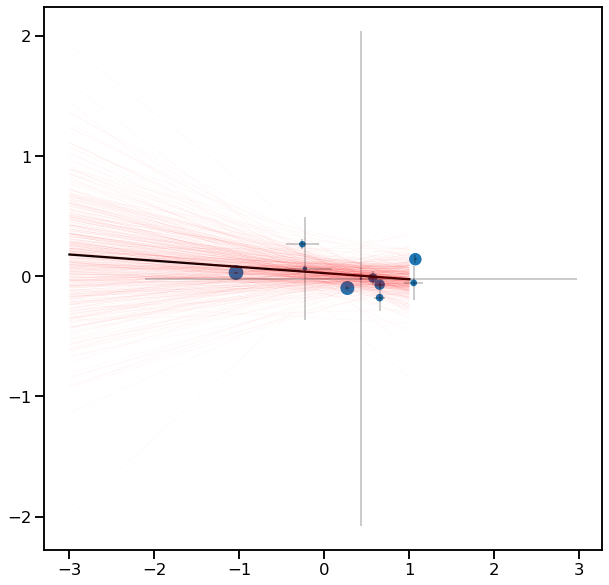

In [33]:
vmin, vmax = -3.0, 1.0
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)

In [34]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(0.0264179975774544, -0.051547037318694776)

In [35]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.09128650606531932, 0.1258203913679326)

In [36]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      m   R-squared:                       0.143
Model:                            WLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.332
Date:                Fri, 22 Oct 2021   Prob (F-statistic):              0.282
Time:                        08:49:11   Log-Likelihood:                0.88843
No. Observations:                  10   AIC:                             2.223
Df Residuals:                       8   BIC:                             2.828
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0082      0.030     -0.269      

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


r0 vs sig

In [37]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','log sig [km/s]', 'siger']]

[Text(0, 0.5, 'log sig [km/s]'), Text(0.5, 0, 'log$ r_{0}$ [pc]')]

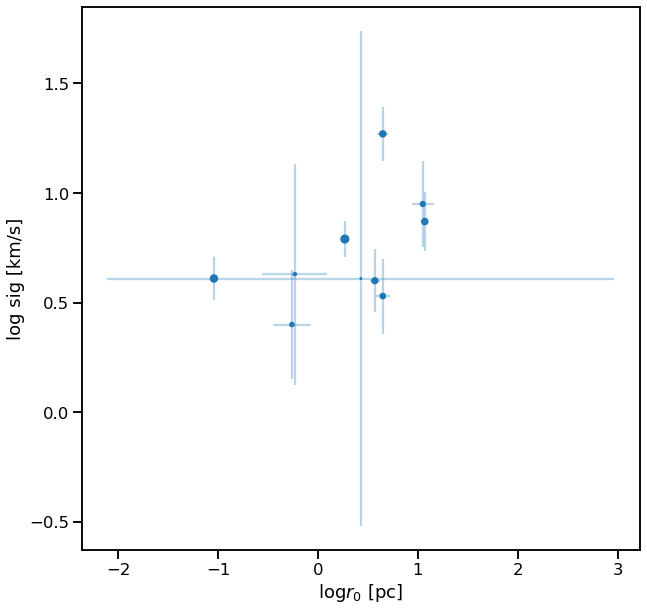

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log$ r_{0}$ [pc]", ylabel=r"log sig [km/s]",
)
#ax.set_aspect("equal")
#sns.despine()

In [39]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [40]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99869085 1.02204797 1.00386897 1.05913766 1.0026828  1.00756609]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00811413 1.02521654 0.99815505 1.0087912  1.0011679  1.00817995]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00150567 1.01097366 1.0058828  0.99822478 1.00086232 1.01458233]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00350257 1.00533735 1.00471551 0.99960903 0.99904562 1.00846343]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00049942 1.00362776 1.01451314 0.9987731  0.99927468 1.00625589]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00016958 1.00180671 1


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00019665 1.00030538 1.00218727 1.00100893 0.99997221 1.00098712]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00022627 1.00033844 1.00222569 1.00088871 0.99994282 1.0010103 ]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00026619 1.00034445 1.00225596 1.00086151 0.9999439  1.00103051]


In [41]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,0.808096,-0.468953,0.200956,"[0.3451938117879407, 0.6548061882120593]","[-0.20165011242116287, 0.5262290627879421]","[3.0137086275125493, 0.16694895672509938]",0.354826,0.525913,0.532937,0.274970,1.126671,-0.762524
1,0.931015,-0.434215,0.291200,"[0.38831344612859914, 0.611686553871401]","[0.5727336655793465, 0.5540772056366932]","[5.274527424263071, 0.1221167406265582]",0.633646,0.261620,0.336098,0.561322,1.457035,-0.760832
2,0.546332,0.144779,0.134307,"[0.10891213543016753, 0.8910878645698325]","[-0.2810072056758084, 0.5279296047682295]","[0.7023607245152788, 0.15329603417858267]",0.004729,0.115034,0.547776,0.439827,0.525931,0.203427
3,0.553591,0.185632,0.120995,"[0.1531387316145609, 0.846861268385439]","[0.009023714145582784, 0.5771036828965579]","[0.6920446476584841, 0.6417729657669663]",0.332462,0.518899,1.069915,0.490109,0.831459,0.405587
4,0.633161,-0.460404,0.212875,"[0.22933737292243042, 0.7706626270775696]","[-0.9783913761830885, 0.43711552814700844]","[0.5624534591200937, 0.12756984718149456]",-0.534617,0.328813,0.174549,0.112487,0.762519,-0.605537
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.710979,0.142560,0.095611,"[0.6378377146972569, 0.36216228530274314]","[0.35992309313670506, 0.9990068984147376]","[0.3745222301335046, 0.12700471101703079]",1.336812,0.421792,0.546657,0.591375,0.615815,0.273124
9996,0.679525,0.275056,0.109269,"[0.6368367430132527, 0.3631632569867474]","[0.0792888363535943, 0.42702454434859605]","[0.5060318956155967, 0.12851336307710615]",0.550174,0.156092,0.361419,0.205574,0.629998,0.464290
9997,0.645518,0.064448,0.281238,"[0.9186362887422909, 0.08136371125770903]","[0.24047873920074123, 0.7443544454798379]","[0.39552603563411404, 1.0337888387507725]",0.021000,0.254696,1.078187,0.281476,0.682960,0.082713
9998,0.625278,0.474675,0.277699,"[0.7547565271142394, 0.24524347288576068]","[0.2389183115321306, 0.37274826265837163]","[0.8586016619013538, 3.7797743009081706]",0.451662,0.303701,1.700201,0.271739,1.256310,0.749345


In [42]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.701158,0.168458,0.126695,0.306716,0.291022,0.583408,0.334845,1.004026,0.385284
std,0.147465,0.195896,0.182010,0.524504,0.175623,0.575610,0.278425,2.610356,0.362357
min,-1.053120,-1.373852,0.000148,-1.944355,0.001154,0.002639,-1.282749,0.332157,-0.998964
25%,0.618097,0.059236,0.046172,-0.003434,0.139661,0.200082,0.170589,0.652749,0.158056
50%,0.705653,0.167425,0.081221,0.327477,0.273074,0.407563,0.344239,0.795193,0.443128
75%,0.789320,0.277818,0.146608,0.626980,0.429357,0.769825,0.509826,0.998075,0.662657
max,1.824194,2.201479,6.823499,2.782670,0.646435,7.017054,1.658186,198.382026,0.999991


In [43]:
pearsonr(X, Y)

(0.49773455259367877, 0.14321343026053712)

In [44]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.00000,10.000000
mean,0.316000,0.341603,0.72600,0.282895
std,0.656475,0.777745,0.25114,0.320495
min,-1.040000,0.020838,0.40000,0.081797
25%,-0.105000,0.033614,0.60250,0.127061
50%,0.500000,0.061517,0.62000,0.157692
75%,0.650000,0.172202,0.85000,0.234335
max,1.070000,2.538500,1.27000,1.127440


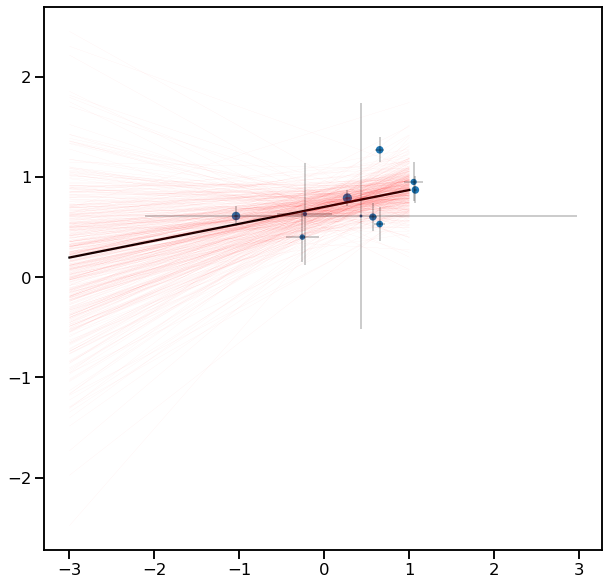

In [45]:
vmin, vmax = -3.0, 1.0
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)

In [46]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(0.7011576815751867, 0.16845766722638963)

In [47]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.14746546990833093, 0.1958961898669668)

In [48]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:         log sig [km/s]   R-squared:                       0.249
Model:                            WLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     2.656
Date:                Fri, 22 Oct 2021   Prob (F-statistic):              0.142
Time:                        08:49:17   Log-Likelihood:                -1.2886
No. Observations:                  10   AIC:                             6.577
Df Residuals:                       8   BIC:                             7.182
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7476      0.073     10.302      

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


sig vs m

In [49]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log sig [km/s]', 'siger','m', 'mer']]

In [50]:
Y=np.log10(Y)

[Text(0, 0.5, 'log m'), Text(0.5, 0, 'log sig [km/s]')]

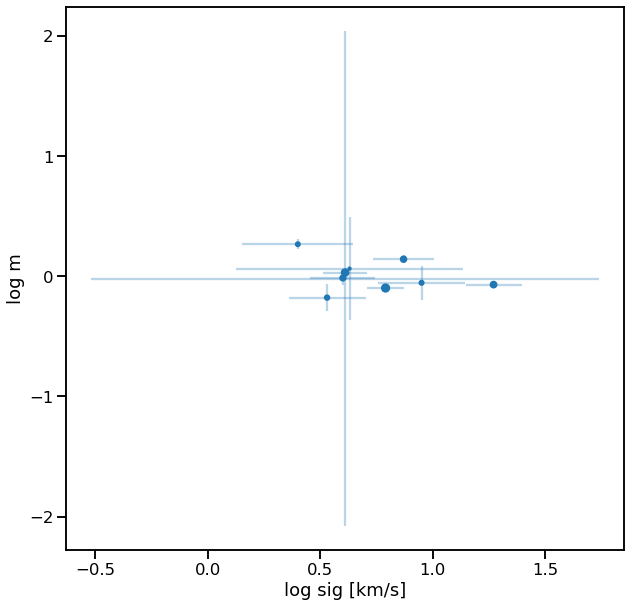

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log sig [km/s]", ylabel=r"log m",
)
#ax.set_aspect("equal")
#sns.despine()

In [52]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [53]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00901554 1.00783227 1.02998403 1.01737567 1.00041131 1.03111776]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01024395 1.00920521 1.02147435 1.03155556 1.00002925 1.01916994]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01809689 1.01813399 1.01238165 1.01537542 1.00054596 1.03739956]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01048412 1.0103314  1.00767027 1.0067133  1.00041989 1.02109688]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00557912 1.00614442 1.00707131 1.01081382 1.0002311  1.01530382]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00501633 1.005795   1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00027148 1.00032224 1.00049792 1.00096115 0.99996866 1.00133502]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00027924 1.00032782 1.0005157  1.00102892 0.99996929 1.00120335]


In [54]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,0.193364,-0.221549,0.010002,"[0.6708981760343223, 0.32910182396567766]","[0.7786601723394023, 0.9820577454015333]","[0.020025482765058007, 0.4934219508340692]",1.006960,0.064274,0.023307,0.845599,0.430065,-0.689780
1,0.379685,-0.509066,0.022469,"[0.7584070306429479, 0.24159296935705207]","[0.80808190647793, 1.0119189830364064]","[0.012784716113630386, 0.7724361162719218]",0.778732,0.019381,0.048847,0.857328,0.451580,-0.837656
2,0.472073,-0.603952,0.010368,"[0.5550159292049927, 0.44498407079500724]","[0.7606843580109969, 0.7590388657078256]","[0.011785004766627175, 0.16539373497889964]",0.879595,0.035875,0.022975,0.759952,0.283089,-0.859174
3,0.072607,-0.168733,0.019407,"[0.7450914883316645, 0.25490851166833556]","[0.8399669952508964, 1.1638636961213913]","[0.025941893748832198, 0.25784549535736495]",0.937752,0.057562,0.100222,0.922531,0.324008,-0.365319
4,0.170525,-0.315277,0.056781,"[0.9740937669061397, 0.02590623309386034]","[0.8227509596977978, 1.0363064558139305]","[0.022111590218050575, 0.28115727653200506]",1.033716,0.031329,0.048983,0.828283,0.173128,-0.223282
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.703298,-0.861739,0.007372,"[0.4274472301380837, 0.5725527698619164]","[0.8126009601420294, 0.7751983066092537]","[0.011349882592408982, 0.021038381463837883]",0.823377,0.019477,0.027689,0.791186,0.131299,-0.796607
9996,1.070665,-1.312845,0.016586,"[0.3013881129343019, 0.6986118870656981]","[0.7918784587911318, 0.7483272063128918]","[0.0059626187401603204, 0.027631522569396938]",0.684228,0.025341,0.006939,0.761453,0.146629,-0.831147
9997,1.284813,-1.498172,0.009072,"[0.46492759671655415, 0.5350724032834459]","[0.7984465400515641, 0.7783819097156072]","[0.0027835035040312864, 0.012044869802313311]",0.819548,0.004917,0.008970,0.787711,0.088539,-0.812290
9998,1.018086,-1.179991,0.015450,"[0.4926772733807476, 0.5073227266192523]","[0.853796732378852, 0.8370200716452307]","[0.004669725303524572, 0.0015689903227564096]",0.798249,0.007650,0.001508,0.845286,0.056276,-0.471212


In [55]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.159861,-0.193142,0.046559,0.772714,0.036952,0.063351,0.760248,0.336931,-0.246834
std,0.519111,0.682786,0.061229,0.193101,0.026210,0.070038,0.103762,1.263331,0.441441
min,-15.576450,-4.858789,0.000487,-0.220908,0.000015,0.000030,0.174344,0.005496,-0.999926
25%,-0.027842,-0.465072,0.017299,0.660207,0.014371,0.017429,0.697605,0.188704,-0.602392
50%,0.173798,-0.210225,0.029866,0.768187,0.031504,0.041068,0.761490,0.251786,-0.293952
75%,0.375147,0.048799,0.053802,0.885104,0.057287,0.083095,0.824341,0.336043,0.058126
max,3.790275,21.503896,2.062935,1.697051,0.094588,0.810589,1.181202,77.803773,0.999862


In [56]:
pearsonr(X, Y)

(-0.3262086480180972, 0.35762694385866756)

In [57]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.00000,10.000000,10.000000,10.000000
mean,0.72600,0.282895,0.007048,0.293355
std,0.25114,0.320495,0.127092,0.632195
min,0.40000,0.081797,-0.177767,0.006752
25%,0.60250,0.127061,-0.065803,0.029443
50%,0.62000,0.157692,-0.016492,0.051073
75%,0.85000,0.234335,0.055556,0.134952
max,1.27000,1.127440,0.266702,2.056800


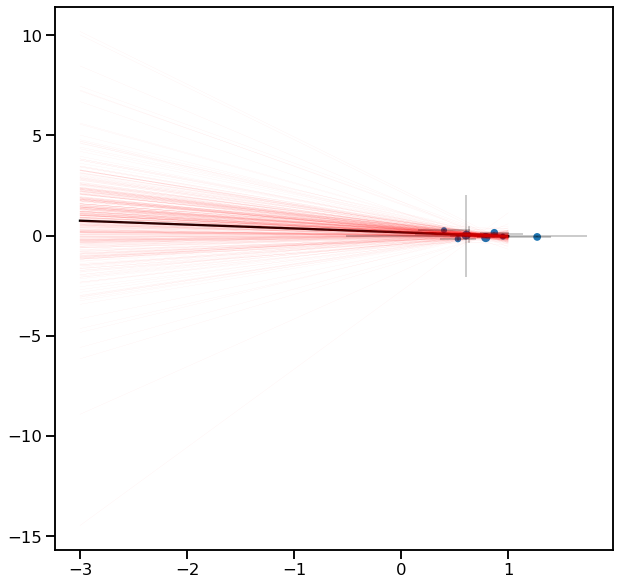

In [58]:
vmin, vmax = -3.0, 1.0
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)

In [59]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(0.15986064679884177, -0.19314188293615478)

In [60]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.5191106810474079, 0.6827863241793604)

In [61]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      m   R-squared:                       0.299
Model:                            WLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     3.418
Date:                Fri, 22 Oct 2021   Prob (F-statistic):              0.102
Time:                        08:49:23   Log-Likelihood:                 1.8967
No. Observations:                  10   AIC:                            0.2065
Df Residuals:                       8   BIC:                            0.8117
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1624      0.080      2.

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Diam(R) vs r0

In [62]:
X, Y, Ye = [logdata[_] for _ in ['log L [pc]', 'log r0 [pc]', 'r0er']]

[Text(0, 0.5, 'log r0 [pc]'), Text(0.5, 0, 'log L [pc]')]

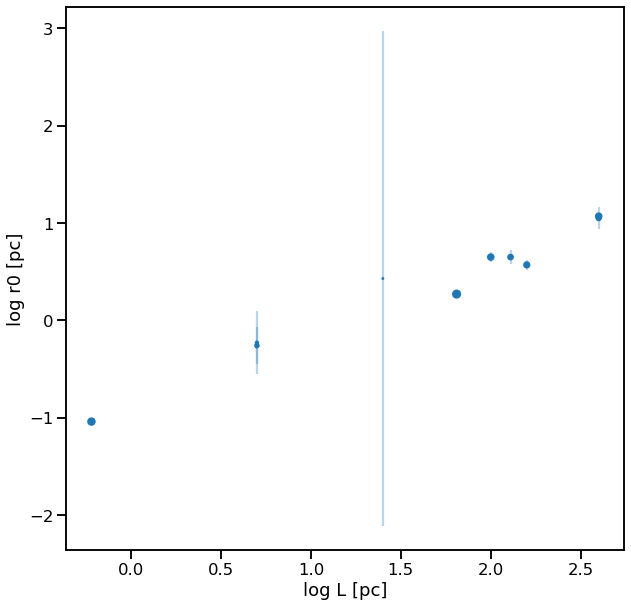

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log L [pc]", ylabel=r"log r0 [pc]",
)
#ax.set_aspect("equal")
#sns.despine()

In [64]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:            log r0 [pc]   R-squared:                       0.986
Model:                            WLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     551.5
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.15e-08
Time:                        08:49:24   Log-Likelihood:                 1.0119
No. Observations:                  10   AIC:                             1.976
Df Residuals:                       8   BIC:                             2.581
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9196      0.064    -14.391      0.0

L vs sig

In [65]:
X, Y, Ye = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'log sig [km/s]', 'siger']]

[Text(0, 0.5, 'log sig [km/s]'), Text(0.5, 0, 'log L(H) [erg s^-1]')]

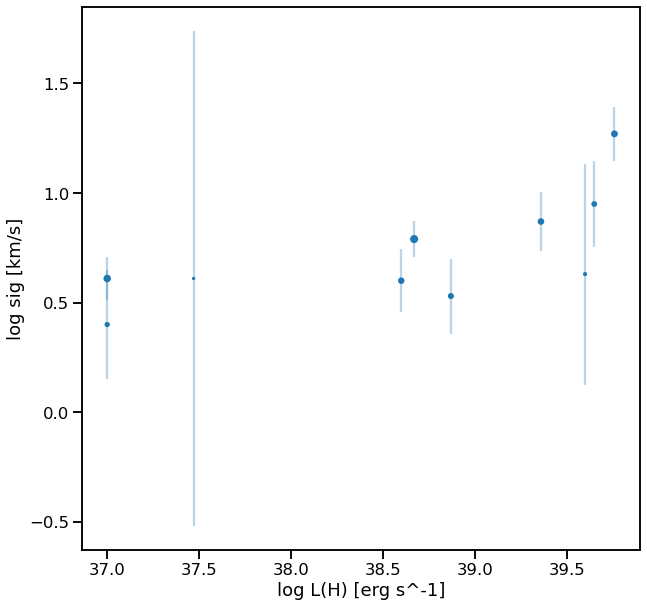

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log L(H) [erg s^-1]", ylabel=r"log sig [km/s]",
)
#ax.set_aspect("equal")
#sns.despine()

In [67]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:         log sig [km/s]   R-squared:                       0.544
Model:                            WLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     9.561
Date:                Fri, 22 Oct 2021   Prob (F-statistic):             0.0148
Time:                        08:49:24   Log-Likelihood:                 1.2094
No. Observations:                  10   AIC:                             1.581
Df Residuals:                       8   BIC:                             2.186
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.9574    

In [68]:
X, Y, Ye = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'log sig [km/s]', 'siger']]

In [69]:
x,y=Y,X
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     log L(H) [erg s^-1]   R-squared:                       0.468
Model:                             OLS   Adj. R-squared:                  0.401
Method:                  Least Squares   F-statistic:                     7.027
Date:                 Fri, 22 Oct 2021   Prob (F-statistic):             0.0292
Time:                         08:49:24   Log-Likelihood:                -11.281
No. Observations:                   10   AIC:                             26.56
Df Residuals:                        8   BIC:                             27.17
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             36.4627      0.8

Distance (D) vs m

In [70]:
X, Y, Ye = [logdata[_] for _ in ['log Dist [kpc]', 'm', 'mer']]

[Text(0, 0.5, 'log m'), Text(0.5, 0, 'log Dist [kpc]')]

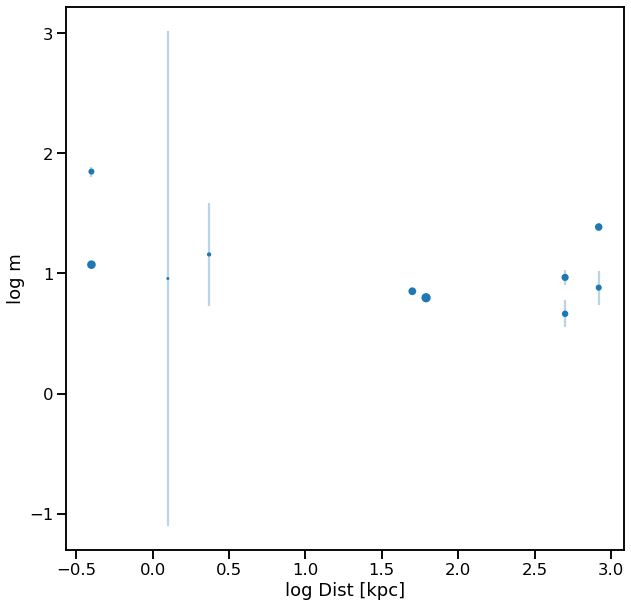

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log Dist [kpc]", ylabel=r"log m",
)
#ax.set_aspect("equal")
#sns.despine()

In [72]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      m   R-squared:                       0.142
Model:                            WLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.325
Date:                Fri, 22 Oct 2021   Prob (F-statistic):              0.283
Time:                        08:49:25   Log-Likelihood:                -8.7119
No. Observations:                  10   AIC:                             21.42
Df Residuals:                       8   BIC:                             22.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0588      0.053     19.

sig vs siglos

In [73]:
X, Y, Ye = [logdata[_] for _ in ['log siglos [km/s]', 'log sig [km/s]', 'siger']]

[Text(0, 0.5, 'log sig [km/s]'), Text(0.5, 0, 'log siglos [km/s]')]

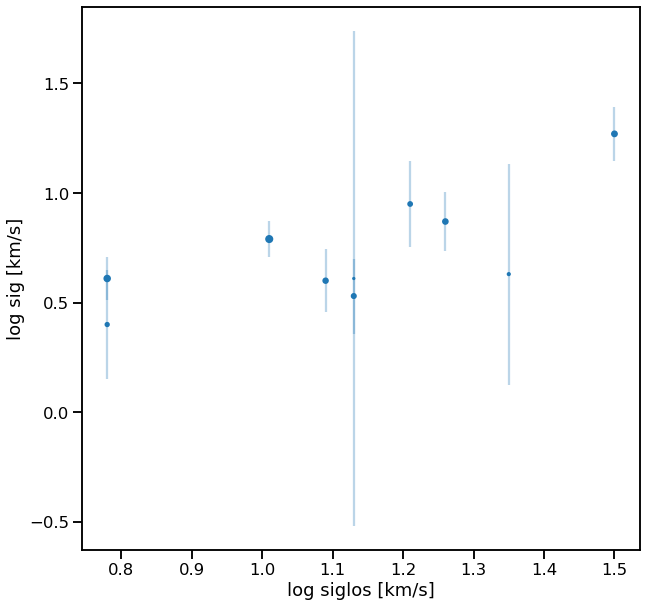

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log siglos [km/s]", ylabel=r"log sig [km/s]",
)
#ax.set_aspect("equal")
#sns.despine()

In [75]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:         log sig [km/s]   R-squared:                       0.676
Model:                            WLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     16.66
Date:                Fri, 22 Oct 2021   Prob (F-statistic):            0.00353
Time:                        08:49:25   Log-Likelihood:                 2.9066
No. Observations:                  10   AIC:                            -1.813
Df Residuals:                       8   BIC:                            -1.208
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1085      0.22

L vs siglos

In [76]:
Moiseev=pd.read_csv('DataOthers//Moiseev2015.csv')
Ostin=pd.read_csv('DataOthers//Ostin2001.csv')
Blasco=pd.read_csv('DataOthers//Blasco2013.csv')
Rozas=pd.read_csv('DataOthers//Rozas2006.csv')
Ars=pd.read_csv('DataOthers//ArsRoy1986.csv')
Wis=pd.read_csv('DataOthers//Wis2012.csv')
Gal=pd.read_csv('DataOthers//Gallagher1983.csv')

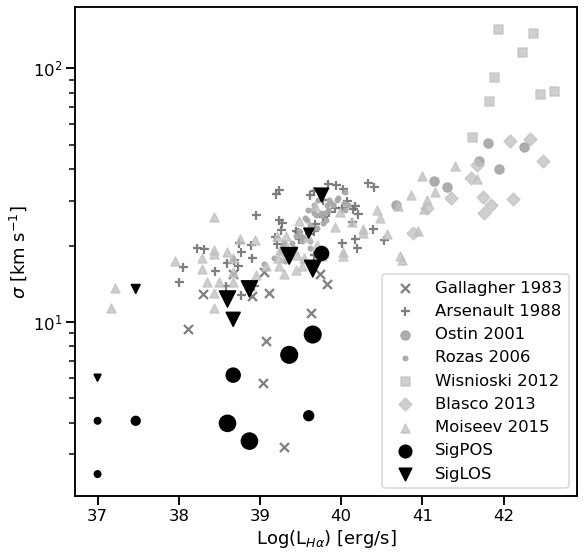

In [77]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Gal.L,Gal.sig,label='Gallagher 1983',marker='x',alpha=0.85,color='dimgray')
plt.scatter(Ars.L,10**Ars.sig,label='Arsenault 1988',marker='+',alpha=0.85,color='dimgray')
plt.scatter(Ostin.L,Ostin.sig,label='Ostin 2001',marker='o',alpha=0.95,color='darkgray')
plt.scatter(Rozas.L,10**(Rozas.sig),label='Rozas 2006',marker='.',alpha=0.95,color='darkgray')
plt.scatter(Wis.L,Wis.sig,label='Wisnioski 2012',marker='s',alpha=0.75,color='silver')
plt.scatter(Blasco.L,Blasco.sig,label='Blasco 2013',marker='D',alpha=0.75,color='silver')
plt.scatter(Moiseev.L,Moiseev.sig,label='Moiseev 2015',marker='^',alpha=0.75,color='silver')

plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')


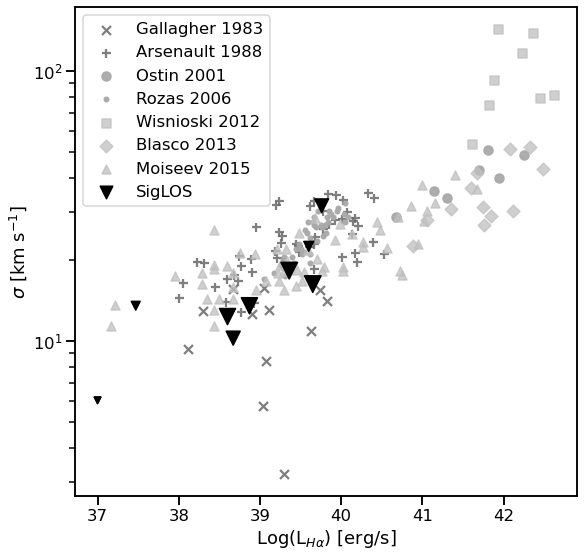

In [78]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Gal.L,Gal.sig,label='Gallagher 1983',marker='x',alpha=0.85,color='dimgray')
plt.scatter(Ars.L,10**Ars.sig,label='Arsenault 1988',marker='+',alpha=0.85,color='dimgray')
plt.scatter(Ostin.L,Ostin.sig,label='Ostin 2001',marker='o',alpha=0.95,color='darkgray')
plt.scatter(Rozas.L,10**(Rozas.sig),label='Rozas 2006',marker='.',alpha=0.95,color='darkgray')
plt.scatter(Wis.L,Wis.sig,label='Wisnioski 2012',marker='s',alpha=0.75,color='silver')
plt.scatter(Blasco.L,Blasco.sig,label='Blasco 2013',marker='D',alpha=0.75,color='silver')
plt.scatter(Moiseev.L,Moiseev.sig,label='Moiseev 2015',marker='^',alpha=0.75,color='silver')

#plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')

In [79]:
globalL= pd.concat([Moiseev.L, Ostin.L.dropna(),Blasco.L.dropna(),Rozas.L.dropna(),Ars.L.dropna(),Wis.L.dropna(),Gal.L.dropna()], axis=0)
globalS= pd.concat([Moiseev.sig, Ostin.sig.dropna(),Blasco.sig.dropna(),10**Rozas.sig.dropna(),10**Ars.sig.dropna(),Wis.sig.dropna(),Gal.sig.dropna()],  axis=0)
GL=np.concatenate((np.array(globalL), np.array(logdata['log L(H) [erg s^-1]'])))
GS=np.concatenate((np.array(globalS), np.array(10**(logdata['log siglos [km/s]']))))

[Text(0, 0.5, 'Log$σ$ [km s$^{-1}$]'), Text(0.5, 0, 'Log(L$_{Hα}$) [erg/s]')]

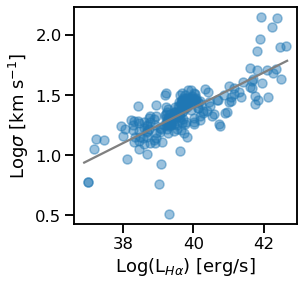

In [80]:
fig, ax=plt.subplots(figsize=(4,4))


plt.scatter(GL, np.log10(GS),alpha=0.45)

x2=np.logspace(1.567,1.63)
y2=-4.4928+0.1472*x2
plt.plot(x2,y2, color='gray')

ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='Log$σ$ [km s$^{-1}$]')


In [81]:
GSer = (GS*.05)/GS

In [82]:
GLer = (GL*.05)/GL

In [83]:
X, Xe, Y, Ye = [GL, GLer, np.log10(GS), GSer]

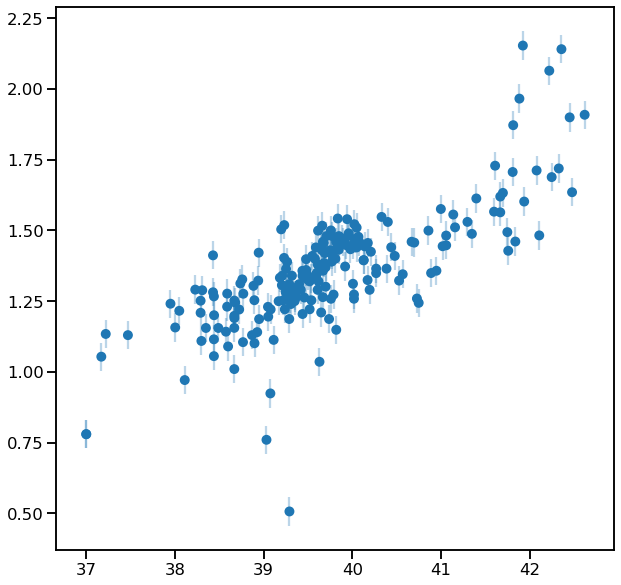

In [84]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
#plt.xscale('log')
#plt.yscale('log')

In [85]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [86]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00479255 1.00454418 1.00248123 1.01899795 0.99733532 1.00925714]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00426151 1.00447144 1.00141385 1.0005027  1.00067357 1.00071526]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00712432 1.00724    0.99866114 0.99840016 0.99750091 1.00009299]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00593514 1.00584466 0.99779667 0.99982778 0.99879139 1.00149044]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00418524 1.00423059 0.99813263 1.00010859 0.9986018  1.00023896]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00418457 1.00416861 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00003289 1.00004135 1.00021485 0.99988593 0.99983702 0.99986882]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00003155 1.00003913 1.00016158 0.99987549 0.9998719  0.99984935]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00009126 1.00009883 1.00011284 0.99989579 0.99986286 0.99982612]


In [87]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,-4.361520,0.143947,0.015284,"[0.4646324424713228, 0.535367557528677]","[39.98478451532337, 39.51164733901933]","[2.36823347372587, 0.2319282741089055]",39.443975,1.765969,0.572836,39.731482,1.131464,0.796519
1,-4.675015,0.151572,0.013686,"[0.4404191983502168, 0.5595808016497833]","[40.1189675276926, 39.586944332636534]","[2.7286180640290434, 0.32610580720165505]",41.305166,0.547052,0.315846,39.821258,1.205809,0.842239
2,-4.452883,0.146232,0.012385,"[0.45190159488966186, 0.5480984051103381]","[40.35474706980376, 39.46561808339963]","[1.5691934588199745, 0.3254670353997196]",39.795194,0.158350,0.675428,39.867417,1.040825,0.807233
3,-4.852840,0.156099,0.014536,"[0.5340007731948944, 0.4659992268051057]","[40.13021906218497, 39.450639184070454]","[2.1495392597534315, 0.28752890534467235]",40.019024,0.245679,0.183807,39.813535,1.181849,0.837098
4,-4.364004,0.144198,0.011109,"[0.48839926753738655, 0.5116007324626134]","[40.059822671985955, 39.56893811564262]","[2.1446257448416386, 0.31429015028424295]",39.511753,0.112773,0.143223,39.808686,1.126248,0.838826
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-4.457420,0.146453,0.014055,"[0.8105985502511918, 0.18940144974880824]","[39.854605980227085, 39.63528707474288]","[1.8495247011293698, 0.12618231359804455]",39.608625,0.348474,0.736079,39.813067,1.237136,0.836778
9996,-4.279850,0.141562,0.015591,"[0.7384379220467476, 0.2615620779532524]","[39.91206637580742, 39.52478817943418]","[1.7471679851919786, 0.10713879340042297]",40.423337,0.573270,0.177828,39.810769,1.160676,0.796186
9997,-4.179692,0.139193,0.018230,"[0.7029810531640595, 0.2970189468359406]","[40.01227413950875, 39.49143363555109]","[1.5719732031702978, 0.1496701897550334]",38.766992,1.420247,0.320267,39.857575,1.098255,0.749516
9998,-4.466792,0.147021,0.013453,"[0.6724099599331417, 0.32759004006685843]","[39.98789258086816, 39.58279766523644]","[1.6832414671968494, 0.21692626859829]",40.593886,0.312764,0.552246,39.855188,1.113121,0.815869


In [88]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-4.501840,0.147459,0.015498,39.754634,0.547080,0.660585,39.741011,1.110780,0.794675
std,0.341089,0.008576,0.001817,0.554306,0.452450,0.560579,0.077065,0.070646,0.030113
min,-5.769047,0.117847,0.009907,37.025313,0.002891,0.003391,39.442776,0.875226,0.669537
25%,-4.730650,0.141793,0.014204,39.453840,0.187055,0.262624,39.688304,1.061698,0.774920
50%,-4.500457,0.147378,0.015372,39.734057,0.402537,0.505337,39.740059,1.107335,0.796319
75%,-4.274682,0.153197,0.016637,40.030521,0.807590,0.883994,39.792483,1.155830,0.816014
max,-3.320881,0.179253,0.025627,43.037338,1.833627,5.100553,40.047270,1.472496,0.879262


In [89]:
pearsonr(X, Y)

(0.77510211505142, 3.80228362815389e-42)

In [90]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,204.000000,2.040000e+02,204.000000,2.040000e+02
mean,39.750147,5.000000e-02,1.359637,5.000000e-02
std,1.105695,4.879636e-17,0.210025,4.875989e-17
min,37.000000,5.000000e-02,0.506911,5.000000e-02
25%,39.156000,5.000000e-02,1.252489,5.000000e-02
50%,39.640500,5.000000e-02,1.349277,5.000000e-02
75%,40.148700,5.000000e-02,1.460000,5.000000e-02
max,42.622000,5.000000e-02,2.153357,5.000000e-02


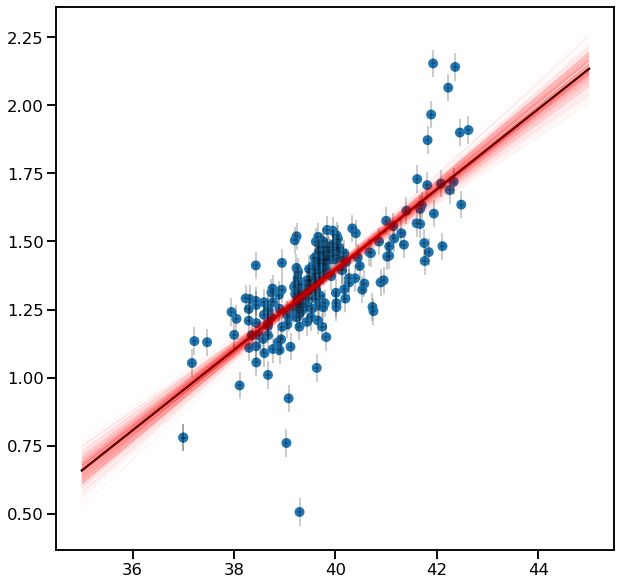

In [91]:
vmin, vmax = 35, 45
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)

In [92]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(-4.50184017536499, 0.147458551713977)

In [93]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.34108941399165693, 0.008575909160216047)

In [94]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            WLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     304.0
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           3.80e-42
Time:                        08:49:46   Log-Likelihood:                 123.05
No. Observations:                 204   AIC:                            -242.1
Df Residuals:                     202   BIC:                            -235.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4928      0.336    -13.380      0.0

In [95]:
Y, Ye, X, Xe = [GL, GLer, np.log10(GS), GSer]

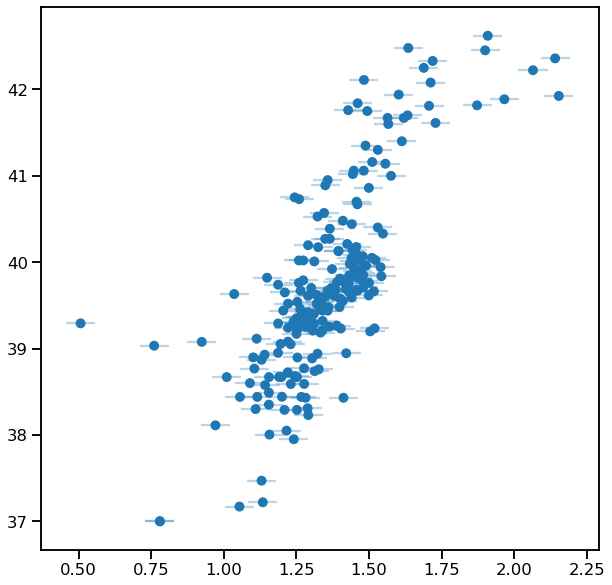

In [96]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

In [97]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [98]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99128692 0.99152932 1.00668406 0.99423293 1.00258092 1.00529962]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99713326 0.99655554 0.99986613 1.01035861 0.99661506 0.99913898]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99844343 0.99788267 0.99756561 1.00688768 0.9992038  0.99752108]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99818039 0.9980953  0.99827112 1.00652243 0.9998526  0.99991291]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99917674 0.99894866 1.00027674 1.00246036 0.9999494  1.00125332]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99886704 0.99886274 1


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99995963 0.99996457 0.99990749 0.99997866 1.00012444 0.99990063]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99993682 0.99994992 0.9998922  0.99991947 1.00008221 0.99990857]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9998909  0.99991022 0.99990711 0.99987473 1.00018346 0.99995861]


In [99]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,34.670659,3.708323,0.526574,"[0.17985079286378297, 0.820149207136217]","[1.3150569019776361, 1.3533934823362137]","[0.1590551190360087, 0.015730652913050085]",1.472600,0.041983,0.034661,1.346499,0.204266,0.722115
1,33.635615,4.472051,0.424034,"[0.2191465829044411, 0.7808534170955589]","[1.4378473085546917, 1.3594723611605382]","[0.14106257664256427, 0.014511306171350782]",1.390390,0.015386,0.017282,1.376648,0.208076,0.819311
2,33.994063,4.225070,0.484740,"[0.26662916072022524, 0.7333708392797746]","[1.374700937962871, 1.3657219598991446]","[0.13582448024534996, 0.014071611419067166]",1.254089,0.038940,0.042908,1.368116,0.215755,0.794719
3,33.709699,4.369676,0.465598,"[0.2464140924194886, 0.7535859075805115]","[1.3280040638852166, 1.3675991929848514]","[0.14067851805600923, 0.01383572128829944]",1.262978,0.024698,0.025490,1.357842,0.213032,0.806529
4,34.103253,4.149861,0.440246,"[0.32234531615808065, 0.6776546838419193]","[1.3373696335682155, 1.3725832122025892]","[0.1445137104814534, 0.014629523694367109]",1.324711,0.003280,0.006747,1.361232,0.238260,0.830362
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,33.844642,4.346005,0.461235,"[0.2500312193004956, 0.7499687806995043]","[1.384268103447901, 1.333383429017011]","[0.147444503032223, 0.017074231290728513]",1.286011,0.023860,0.053682,1.346106,0.223956,0.820093
9996,34.163011,4.098815,0.451924,"[0.1690001425390886, 0.8309998574609114]","[1.4757901429657514, 1.331912773227486]","[0.11557606695167193, 0.01549922425274968]",1.541217,0.065358,0.016792,1.356228,0.187935,0.753433
9997,34.342324,3.969789,0.419527,"[0.1804078753172225, 0.8195921246827775]","[1.46067316999195, 1.347307770675459]","[0.14213567091813514, 0.016015133499200997]",1.665817,0.012365,0.027251,1.367760,0.201664,0.777419
9998,34.064632,4.073625,0.386269,"[0.22697865620640773, 0.7730213437935923]","[1.4512473684512701, 1.348189899131108]","[0.1973421632476662, 0.01781752517145944]",1.373437,0.008359,0.029589,1.371582,0.245824,0.849659


In [100]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,33.935404,4.276723,0.469761,1.376933,0.021992,0.036031,1.358268,0.208681,0.790271
std,0.349497,0.254959,0.052539,0.110022,0.016674,0.028756,0.014754,0.019754,0.035997
min,32.631562,3.284091,0.318666,0.629662,0.000137,0.000253,1.297513,0.150162,0.651104
25%,33.698390,4.106886,0.432926,1.315344,0.008294,0.015315,1.348434,0.195012,0.766948
50%,33.937918,4.273346,0.466258,1.373490,0.017539,0.028477,1.358224,0.206616,0.791476
75%,34.169132,4.448917,0.502707,1.437804,0.032451,0.048959,1.368064,0.220226,0.815560
max,35.273513,5.236550,0.830576,1.957088,0.066158,0.244846,1.412228,0.350810,0.925259


In [101]:
pearsonr(X, Y)

(0.77510211505142, 3.80228362815389e-42)

In [102]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,204.000000,2.040000e+02,204.000000,2.040000e+02
mean,1.359637,5.000000e-02,39.750147,5.000000e-02
std,0.210025,4.875989e-17,1.105695,4.879636e-17
min,0.506911,5.000000e-02,37.000000,5.000000e-02
25%,1.252489,5.000000e-02,39.156000,5.000000e-02
50%,1.349277,5.000000e-02,39.640500,5.000000e-02
75%,1.460000,5.000000e-02,40.148700,5.000000e-02
max,2.153357,5.000000e-02,42.622000,5.000000e-02


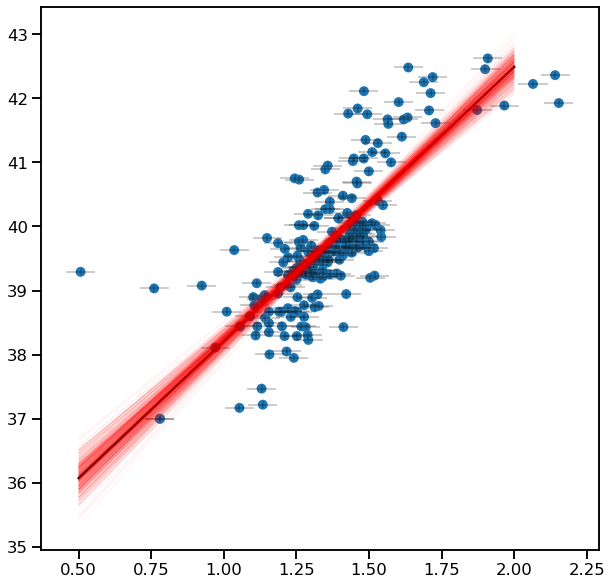

In [103]:
vmin, vmax = 0.5, 2
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.4, lw=0.1)


In [104]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(33.935403628789594, 4.276723149261662)

In [105]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.3494968424070766, 0.2549594512717626)

In [106]:
print("--- %s seconds ---" % (time.time()-start_time))


--- 90.68784856796265 seconds ---
